In [257]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score 

In [258]:
from label import label

In [259]:
df = label('../binance-BTCUSDT-1m.csv', t=15)

In [260]:
df

,Open,High,Low,Close,Volumn,Timestamp End,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,Time_UTC_Start,label
Timestamp,,,,,,,,,,,,
1531910340000,7370.00,7404.23,7365.10,7402.13,421.446875,1531911239999,3.112218e+06,2210,244.531743,1.805624e+06,2018-07-18 10:39:00,1.0
1531911240000,7404.23,7419.09,7393.03,7398.00,400.220193,1531912139999,2.963666e+06,2825,217.698269,1.612081e+06,2018-07-18 10:54:00,0.0
1531912140000,7397.00,7413.67,7388.97,7401.99,283.424582,1531913039999,2.097944e+06,2022,158.367674,1.172256e+06,2018-07-18 11:09:00,1.0
1531913040000,7401.99,7433.32,7395.00,7430.33,385.377189,1531913939999,2.858399e+06,2194,230.656692,1.711215e+06,2018-07-18 11:24:00,1.0
1531913940000,7430.33,7433.58,7408.07,7418.00,412.557017,1531914839999,3.061536e+06,2352,231.403556,1.717226e+06,2018-07-18 11:39:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1651905540000,35858.19,35878.00,35795.54,35795.55,231.841700,1651906439999,8.311628e+06,5817,86.377500,3.096591e+06,2022-05-07 06:39:00,0.0
1651906440000,35795.54,35832.12,35790.02,35812.80,154.689420,1651907339999,5.539456e+06,5981,91.672010,3.282832e+06,2022-05-07 06:54:00,1.0
1651907340000,35812.81,35870.00,35800.00,35867.66,613.847520,1651908239999,2.198320e+07,7098,179.258800,6.422060e+06,2022-05-07 07:09:00,1.0


In [261]:
del df['Timestamp End'], df['Time_UTC_Start']

In [262]:
df['Open_change'] = df['Open'] - df['Open'].shift(1)
df['High_change'] = df['High'] - df['High'].shift(1)
df['Low_change'] = df['Low'] - df['Low'].shift(1)
df['Close_change'] = df['Close'] - df['Close'].shift(1)
df = df.dropna()

In [263]:
df['Close_change'].shift(1).rolling(3).agg({"min_close":'min', 'max_close':'max'})

,min_close,max_close
Timestamp,,
1531911240000,NaN,NaN
1531912140000,NaN,NaN
1531913040000,NaN,NaN
1531913940000,-4.13,28.34
1531914840000,-12.33,28.34
...,...,...
1651905540000,-43.84,51.04
1651906440000,-62.64,51.04
1651907340000,-62.64,51.04


In [264]:
df['Close_change']

Timestamp
1531911240000    -4.13
1531912140000     3.99
1531913040000    28.34
1531913940000   -12.33
1531914840000     0.29
                 ...  
1651905540000   -62.64
1651906440000    17.25
1651907340000    54.86
1651908240000    35.08
1651909140000    48.95
Name: Close_change, Length: 133332, dtype: float64

In [265]:
base_cols = list(df.columns)

In [266]:
base_cols = base_cols[4:]

In [267]:
base_cols.remove('label')

In [268]:
import gc
def base_feat(df, base_cols=[], 
                  time_delta=1, 
                  window_lookback=[5, 10, 60, 200, 500],
                  agg_func=['min', 'max', 'mean', 'median', 'var']):
    """
    This func use for create formal features base on a list of columns
    Params:
        df (Pandas DF): dataframe input
        base_cols (list): list of columns you want to create feature by this function
        time_delta (int): time between 2 records (minutes)
        window_lookback (list): list of integer time the time_delta. For example time_delta = 15 window_lookback = [1, 2]
                                so the time lookback is 15 minutes and 15*2=30 minutes
        agg_func (list): aggregate func you use for rolling
    """
        
    for col in base_cols:
        for lookback in window_lookback:
            dict_agg_func = {'_'.join([agg, col, str(time_delta * lookback) + 'M']): agg for agg in agg_func}
            df_feat = df[col].shift(1).rolling(lookback).agg(dict_agg_func)
            df = pd.concat([df, df_feat], axis=1)
            del df_feat
            gc.collect()
    for col in df.columns:
        if '1' in col and 'var' in col:
            del df[col]
    df = df.dropna()
    return df

In [269]:
df_feat = base_feat(df, base_cols=base_cols)

In [270]:
feat = df_feat.columns[14:]

In [271]:
df_feat.shape

(132832, 230)

In [272]:
feat

Index(['min_Volumn_5M', 'max_Volumn_5M', 'mean_Volumn_5M', 'median_Volumn_5M',
       'var_Volumn_5M', 'min_Volumn_10M', 'max_Volumn_10M', 'mean_Volumn_10M',
       'median_Volumn_10M', 'min_Volumn_60M',
       ...
       'min_Close_change_200M', 'max_Close_change_200M',
       'mean_Close_change_200M', 'median_Close_change_200M',
       'var_Close_change_200M', 'min_Close_change_500M',
       'max_Close_change_500M', 'mean_Close_change_500M',
       'median_Close_change_500M', 'var_Close_change_500M'],
      dtype='object', length=216)

# Test features

In [273]:
for f in feat:
    scaler = preprocessing.StandardScaler()
    df_feat[f] = scaler.fit_transform(df_feat[[f]])

In [274]:
df_feat

,Open,High,Low,Close,Volumn,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,label,...,min_Close_change_200M,max_Close_change_200M,mean_Close_change_200M,median_Close_change_200M,var_Close_change_200M,min_Close_change_500M,max_Close_change_500M,mean_Close_change_500M,median_Close_change_500M,var_Close_change_500M
Timestamp,,,,,,,,,,,,,,,,,,,,,
1532361240000,7741.13,7747.21,7725.02,7731.00,380.066531,2.939918e+06,2292,193.695606,1.498316e+06,0.0,...,0.510174,-0.665610,0.220521,0.197136,-0.477396,0.538651,-0.689578,0.092251,0.203616,-0.519414
1532362140000,7731.00,7743.34,7698.02,7729.15,658.501311,5.082207e+06,2913,323.362969,2.496556e+06,0.0,...,0.510174,-0.665610,0.195658,0.178449,-0.477494,0.538651,-0.689578,0.089778,0.203616,-0.519407
1532363040000,7735.58,7749.00,7722.73,7729.99,287.894207,2.227859e+06,2367,128.856921,9.972310e+05,0.0,...,0.510174,-0.665610,0.200699,0.178449,-0.477514,0.538651,-0.689578,0.087376,0.184624,-0.519408
1532363940000,7730.49,7740.00,7723.00,7733.17,217.210836,1.679909e+06,1968,130.330289,1.008019e+06,1.0,...,0.510174,-0.665610,0.204524,0.178449,-0.477522,0.538651,-0.689578,0.076064,0.169630,-0.519465
1532364840000,7734.98,7745.01,7732.77,7745.00,383.939547,2.971080e+06,2262,273.541665,2.116857e+06,1.0,...,0.510174,-0.665610,0.212185,0.197136,-0.477541,0.538651,-0.689578,0.082444,0.184624,-0.519477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651905540000,35858.19,35878.00,35795.54,35795.55,231.841700,8.311628e+06,5817,86.377500,3.096591e+06,0.0,...,-1.550240,0.133346,-2.482126,-1.877844,0.199410,-0.937740,0.570841,-1.165858,-1.372695,-0.024273
1651906440000,35795.54,35832.12,35790.02,35812.80,154.689420,5.539456e+06,5981,91.672010,3.282832e+06,1.0,...,-1.550240,0.133346,-2.550661,-1.988584,0.199027,-0.937740,0.570841,-1.181324,-1.372695,-0.024060
1651907340000,35812.81,35870.00,35800.00,35867.66,613.847520,2.198320e+07,7098,179.258800,6.422060e+06,1.0,...,-1.550240,0.133346,-2.540043,-1.988584,0.199187,-0.937740,0.570841,-1.162160,-1.292730,-0.024064


### train test split

In [275]:
X, y = df_feat[feat], df_feat['label']
X_train, X_valid, X_test = X[:int(df_feat.shape[0]*0.7)], X[int(df_feat.shape[0]*0.7):int(df_feat.shape[0]*0.85)], X[int(df_feat.shape[0]*0.85):]
y_train, y_valid, y_test = y[:int(df_feat.shape[0]*0.7)], y[int(df_feat.shape[0]*0.7):int(df_feat.shape[0]*0.85)], y[int(df_feat.shape[0]*0.85):]

## logistic model


In [276]:
from sklearn.linear_model import LogisticRegression

In [277]:
clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=0.1, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=1234, solver='lbfgs', max_iter=100, multi_class='auto', verbose=1)

In [278]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


LogisticRegression(C=0.1, random_state=1234, verbose=1)

In [279]:
y_pred_val = clf.predict_proba(X_valid)

In [280]:
y_pred_val = y_pred_val[:, 1]

(array([2.000e+00, 1.000e+00, 3.000e+00, 9.000e+00, 9.000e+00, 1.700e+01,
        1.700e+01, 1.900e+01, 2.700e+01, 2.000e+01, 5.500e+01, 5.500e+01,
        5.000e+01, 8.900e+01, 7.100e+01, 1.100e+02, 2.000e+02, 2.630e+02,
        3.610e+02, 4.670e+02, 6.300e+02, 8.790e+02, 1.167e+03, 1.539e+03,
        1.983e+03, 2.100e+03, 2.100e+03, 1.900e+03, 1.475e+03, 1.254e+03,
        8.850e+02, 6.100e+02, 4.470e+02, 2.770e+02, 2.410e+02, 1.800e+02,
        1.280e+02, 7.900e+01, 4.700e+01, 4.500e+01, 2.300e+01, 2.600e+01,
        1.900e+01, 1.100e+01, 6.000e+00, 2.000e+00, 6.000e+00, 6.000e+00,
        8.000e+00, 7.000e+00]),
 array([0.00401724, 0.02391561, 0.04381397, 0.06371234, 0.0836107 ,
        0.10350906, 0.12340743, 0.14330579, 0.16320415, 0.18310252,
        0.20300088, 0.22289924, 0.24279761, 0.26269597, 0.28259434,
        0.3024927 , 0.32239106, 0.34228943, 0.36218779, 0.38208615,
        0.40198452, 0.42188288, 0.44178125, 0.46167961, 0.48157797,
        0.50147634, 0.5213747 , 0.54

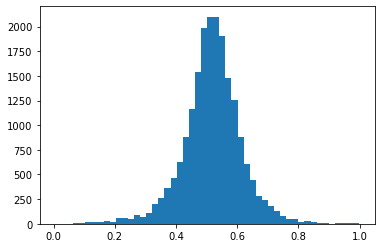

In [281]:
plt.hist(y_pred_val, bins=50)

In [282]:
roc_auc_score(y_test, y_pred_val)

0.49631859378401455

In [283]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()

In [284]:
params = {'objective': 'binary',
                      'metric': ['auc', 'binary_error', 'binary_logloss'],
                      'is_unbalance':True,
                      'boosting':'gbdt',
                      'num_boost_round':1000,
                      'early_stopping_rounds':10,
                      'learning_rate': 0.01,
                      'max_depth': 4,
                      'num_leaves': 32,
                      'feature_fraction': 0.8,
#                       'bagging_fraction': 0.8,
#                       'min_data_in_leaf': 10,
                      'verbosity': 1}

In [285]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [286]:
model = lgb.train(params, train_data,                     
                  valid_sets=[train_data, valid_data],
                  valid_names=['train', 'valid'])

C:\Users\ADMIN\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 47070, number of negative: 45912
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54992
[LightGBM] [Info] Number of data points in the train set: 92982, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506227 -> initscore=0.024909
[LightGBM] [Info] Start training from score 0.024909
[1]	train's auc: 0.547555	train's binary_error: 0.493773	train's binary_logloss: 0.692994	valid's auc: 0.518668	valid's binary_error: 0.496562	valid's binary_logloss: 0.693112
Training until validation scores don't improve for 10 rounds
[2]	train's auc: 0.552478	train's binary_error: 0.493773	train's binary_logloss: 0.692918	valid's auc: 0.519192	valid's binary_error: 0.496562	valid's binary_logloss: 0.693087
[3]	train's auc: 0.552161	

In [287]:
importance_df = (
    pd.DataFrame({
        'feature_name': model.feature_name(),
        'importance_gain': model.feature_importance(importance_type='gain'),
        'importance_split': model.feature_importance(importance_type='split'),
    })
    .sort_values('importance_gain', ascending=False)
    .reset_index(drop=True)
)
importance_df.head(50)

,feature_name,importance_gain,importance_split
0,mean_Close_change_5M,2792.445777,17
1,max_High_change_5M,507.905399,13
2,median_Close_change_5M,462.607700,10
3,min_Close_change_5M,299.670998,5
4,mean_Close_change_10M,272.174396,14
5,max_Close_change_5M,97.936001,4
6,median_Low_change_10M,85.959100,6
7,max_Taker_buy_base_asset_volume_5M,84.690098,3
8,mean_High_change_10M,74.971300,4
9,mean_Number_of_trades_500M,68.200001,4


In [288]:
pred = model.predict(X_test)
y_pred = [round(x) for x in pred]

In [289]:
from sklearn.metrics import classification_report

In [290]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.01      0.03     10002
         1.0       0.50      0.99      0.66      9923

    accuracy                           0.50     19925
   macro avg       0.53      0.50      0.34     19925
weighted avg       0.53      0.50      0.34     19925



(array([4.600e+01, 1.850e+02, 8.000e+00, 4.400e+01, 2.419e+03, 2.104e+03,
        2.229e+03, 1.928e+03, 9.200e+02, 4.230e+02, 1.547e+03, 6.401e+03,
        4.800e+02, 3.800e+01, 2.710e+02, 1.820e+02, 6.730e+02, 1.000e+00,
        0.000e+00, 2.600e+01]),
 array([0.49787997, 0.49876715, 0.49965433, 0.50054151, 0.50142869,
        0.50231587, 0.50320306, 0.50409024, 0.50497742, 0.5058646 ,
        0.50675178, 0.50763896, 0.50852615, 0.50941333, 0.51030051,
        0.51118769, 0.51207487, 0.51296205, 0.51384924, 0.51473642,
        0.5156236 ]),
 <BarContainer object of 20 artists>)

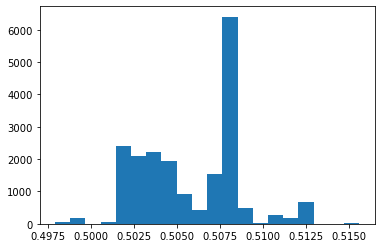

In [291]:
plt.hist(model.predict(X_test), bins=20)

In [292]:
roc_auc_score(y_test, pred)

0.5317901450446583